<a href="https://colab.research.google.com/github/Uthmanic/HAMOYE-DataScience-Internship/blob/master/Hamoye_Stage%20D(Planet%3A%20Understanding%20the%20Amazon%20from%20SpaceAmazon).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install kaggle
!pip install kaggle

In [ ]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [ ]:
import json
token = {"username":"tijaniuthman","key":"42a091ba934aa0b6d9ef884eb7f52567"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                    title                                              size  lastUpdated          downloadCount  
-----------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
anmolkumar/health-insurance-cross-sell-prediction      Health Insurance Cross Sell Prediction 🏠 🏥          6MB  2020-09-11 18:39:31            922  
shivan118/healthcare-analytics                         Healthcare Analytics                                2MB  2020-09-13 17:40:05            512  
Cornell-University/arxiv                               arXiv Dataset                                     885MB  2020-09-14 16:54:47           2836  
nipunarora8/age-gender-and-ethnicity-face-data-csv     AGE, GENDER AND ETHNICITY (FACE DATA) CSV          63MB  2020-09-02 13:46:38            293  
datatattle/covid-19-nlp-text-classification            Coronavirus tweets NLP - Text Classification       

In [ ]:
#search for the dataset 
!kaggle datasets list -s planets-dataset

ref                                               title                                     size  lastUpdated          downloadCount  
------------------------------------------------  ---------------------------------------  -----  -------------------  -------------  
nikitarom/planets-dataset                         planets_dataset                            1GB  2020-02-09 22:01:31           1889  
mrisdal/open-exoplanet-catalogue                  Open Exoplanet Catalogue                 123KB  2017-06-08 19:59:22           2804  
eduardowoj/exoplanets-database                    Exoplanets Database                      281KB  2018-02-28 20:56:05            852  
muhakabartay/markmarkohkeplerconfirmedplanets     Kepler Confirmed Planets                 521KB  2019-12-26 20:08:20             16  
nasa/kepler-exoplanet-search-results              Kepler Exoplanet Search Results            1MB  2017-10-10 18:26:59           3988  
jsphyg/star-wars                                  Star 

In [ ]:
#download dataset
!kaggle datasets download -d nikitarom/planets-dataset -p /content

planets-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#unzip the dataset
!unzip \*.zip

Archive:  planets-dataset.zip
replace planet/planet/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [67]:
#Import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import fbeta_score
from tqdm import tqdm
import cv2
from PIL import Image
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import fbeta_score
import time
%matplotlib inline

pal = sns.color_palette()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [68]:
#check present working directory
! pwd

/content


In [69]:
#read the train and test csv files
df_train = pd.read_csv('/content/planet/planet/train_classes.csv')
df_test = pd.read_csv('/content/planet/planet/sample_submission.csv')

In [70]:
df_test.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


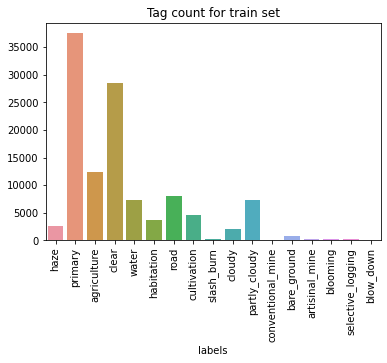

In [71]:
#distribution of train labels 
labels = df_train['tags'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts = defaultdict(int) #dictionary containing each individual label
for l in labels:
    for l2 in l:
        counts[l2] += 1
        
        
tag_list=list(counts.keys()) 
y=list(counts.values())
sns.barplot(x=tag_list, y=y);
plt.xlabel('labels');
plt.xticks(rotation = 90);
plt.title('Tag count for train set');

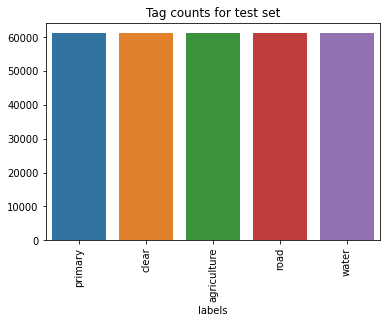

In [72]:
#distribution of test labels 
labels_test = df_test['tags'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts_test = defaultdict(int)
for l in labels_test:
    for l2 in l:
        counts_test[l2] += 1

tag_list_test=list(counts_test.keys()) 
test_count=list(counts_test.values())
sns.barplot(x=tag_list_test, y=test_count);
plt.xlabel('labels');
plt.xticks(rotation = 90);
plt.title('Tag counts for test set');

In [73]:
#assign numerical value to each label using dictionary
label_map = {i:j for j, i in enumerate(tag_list)}
label_map

{'agriculture': 2,
 'artisinal_mine': 13,
 'bare_ground': 12,
 'blooming': 14,
 'blow_down': 16,
 'clear': 3,
 'cloudy': 9,
 'conventional_mine': 11,
 'cultivation': 7,
 'habitation': 5,
 'haze': 0,
 'partly_cloudy': 10,
 'primary': 1,
 'road': 6,
 'selective_logging': 15,
 'slash_burn': 8,
 'water': 4}

In [74]:
# One hot encode the training labels. Convert the images into pixels and resize them
X_train, Y_train = [], []
for img, label in tqdm(df_train.values, miniters = 1000):
  target = np.zeros(17)
  for tag in label.split(' '):
    target[label_map[tag]]=1
  X_train.append(cv2.resize(cv2.imread('/content/planet/planet/train-jpg/{}.jpg'.format(img)), (64,64)))
  Y_train.append(target)



  0%|          | 0/40479 [00:00<?, ?it/s]

  2%|▏         | 1000/40479 [00:01<00:49, 800.84it/s]

  5%|▍         | 2000/40479 [00:02<00:47, 805.32it/s]

  7%|▋         | 3000/40479 [00:03<00:46, 810.88it/s]

 10%|▉         | 4000/40479 [00:04<00:44, 812.43it/s]

 12%|█▏        | 5000/40479 [00:06<00:43, 813.50it/s]

 15%|█▍        | 6000/40479 [00:07<00:42, 812.05it/s]

 17%|█▋        | 7000/40479 [00:08<00:41, 815.63it/s]

 20%|█▉        | 8000/40479 [00:09<00:39, 814.32it/s]

 22%|██▏       | 9000/40479 [00:11<00:38, 817.30it/s]

 25%|██▍       | 10000/40479 [00:12<00:37, 817.18it/s]

 27%|██▋       | 11000/40479 [00:13<00:36, 815.07it/s]

 30%|██▉       | 12000/40479 [00:14<00:34, 815.10it/s]

 32%|███▏      | 13000/40479 [00:15<00:33, 814.28it/s]

 35%|███▍      | 14000/40479 [00:17<00:32, 813.42it/s]

 37%|███▋      | 15000/40479 [00:18<00:31, 810.24it/s]

 40%|███▉      | 16000/40479 [00:19<00:30, 810.78it/s]

 42%|████▏     | 17000/40479 [00:20<00:29, 808.30it/s]

 44%|████▍  

In [75]:
#convert the test images to pixels and resize them as well
X_test=[]
for img, label in tqdm(df_test[:40669].values, miniters = 1000):
  X_test.append(cv2.resize(cv2.imread('/content/planet/planet/test-jpg/{}.jpg'.format(img)), (64,64)))
for img, label in tqdm(df_test[40669:].values, miniters = 1000):
  X_test.append(cv2.resize(cv2.imread('/content/test-jpg-additional/test-jpg-additional/{}.jpg'.format(img)), (64,64)))
x_test = np.array(X_test, np.float16)/255



  0%|          | 0/40669 [00:00<?, ?it/s]

  2%|▏         | 1000/40669 [00:01<00:48, 823.58it/s]

  5%|▍         | 2000/40669 [00:02<00:47, 818.53it/s]

  7%|▋         | 3000/40669 [00:03<00:46, 818.54it/s]

 10%|▉         | 4000/40669 [00:04<00:45, 814.00it/s]

 12%|█▏        | 5000/40669 [00:06<00:44, 810.23it/s]

 15%|█▍        | 6000/40669 [00:07<00:42, 813.48it/s]

 17%|█▋        | 7000/40669 [00:08<00:41, 813.17it/s]

 20%|█▉        | 8000/40669 [00:09<00:40, 811.98it/s]

 22%|██▏       | 9000/40669 [00:11<00:38, 815.22it/s]

 25%|██▍       | 10000/40669 [00:12<00:37, 818.46it/s]

 27%|██▋       | 11000/40669 [00:13<00:36, 814.96it/s]

 30%|██▉       | 12000/40669 [00:14<00:35, 816.04it/s]

 32%|███▏      | 13000/40669 [00:15<00:33, 818.31it/s]

 34%|███▍      | 14000/40669 [00:17<00:32, 820.82it/s]

 37%|███▋      | 15000/40669 [00:18<00:31, 822.58it/s]

 39%|███▉      | 16000/40669 [00:19<00:29, 822.75it/s]

 42%|████▏     | 17000/40669 [00:20<00:28, 823.77it/s]

 44%|████▍  

In [76]:
#Confirm the dimensions
len(X_test), len(X_train), len(Y_train)

(61191, 40479, 40479)

In [77]:
import sys
sys.getsizeof(X_train)

361288

In [78]:
#import and initialise Garbage Collector
import gc
gc.collect()

3353

In [79]:
#Change lists to numpy arrays and normalize
x_train = np.array(X_train, np.float16)/255
y_train = np.array(Y_train, np.uint8)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True, random_state = 1)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(32383, 64, 64, 3) (32383, 17) (8096, 64, 64, 3) (8096, 17)


In [80]:
#delete X_test, X_train, Y_train to free up space
del(X_test, X_train, Y_train)

In [81]:
#Split the data into 5 folds and train on 4 folds while validating on 1 fold

yfull_test = []
yfull_train = []
X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_train, y_train, test_size = 0.2, random_state = 1)

In [82]:
#import and initialise Garbage Collector
import gc
gc.collect()

0

In [83]:
#Build a five layer CNN model

kfold_weights_path = os.path.join('', 'weights_kfold_' + '.h5')
model = Sequential()
model.add(BatchNormalization(input_shape=(64, 64,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
        
model.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
        
model.add(Conv2D(256, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
        
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))



In [96]:
#import and initialise Garbage Collector
import gc
gc.collect()

3848

In [97]:
#Try a combination of epoch lengths and learning rates
epochs = 18
learn_rate = 0.0001
opt  = optimizers.Adam(lr=learn_rate)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=0)]


model.fit(x = X_train_, y= Y_train_, validation_data=(X_val_, Y_val_),batch_size=128,verbose=2, epochs=epochs,callbacks=callbacks,shuffle=True)

p_val = model.predict(X_val_, batch_size = 32, verbose=2)
print(fbeta_score(Y_val_, np.array(p_val) > 0.2, beta=2, average='samples')) #Check the model performance on the validation set

p_train = model.predict(x_train, batch_size =128, verbose=2) #save the training predictions
yfull_train.append(p_train)
        
p_test = model.predict(x_test, batch_size = 128, verbose=2) #save the test predictions
yfull_test.append(p_test)

Epoch 1/18
203/203 - 10s - loss: 0.0988 - accuracy: 0.6999 - val_loss: 0.1138 - val_accuracy: 0.7431
Epoch 2/18
203/203 - 9s - loss: 0.0980 - accuracy: 0.6947 - val_loss: 0.1122 - val_accuracy: 0.6776
Epoch 3/18
203/203 - 9s - loss: 0.0968 - accuracy: 0.6877 - val_loss: 0.1118 - val_accuracy: 0.7013
Epoch 4/18
203/203 - 9s - loss: 0.0954 - accuracy: 0.6899 - val_loss: 0.1121 - val_accuracy: 0.7213
Epoch 5/18
203/203 - 9s - loss: 0.0940 - accuracy: 0.6828 - val_loss: 0.1128 - val_accuracy: 0.6915
203/203 - 1s
0.9051631183118211
253/253 - 3s
479/479 - 6s


In [98]:
#import and initialise Garbage Collector
import gc
gc.collect()

3130

In [99]:
#make predictions
predictions = model.predict(x_test, batch_size = 32)
predictions

array([[2.3544680e-03, 9.9963808e-01, 4.1169049e-03, ..., 3.5079876e-03,
        3.6458764e-04, 2.3640187e-04],
       [6.5702654e-04, 9.9947661e-01, 5.1736841e-03, ..., 1.2424684e-01,
        7.2152643e-03, 6.7639849e-03],
       [2.6289737e-05, 9.9995971e-01, 7.0868325e-03, ..., 1.6698315e-04,
        5.4632867e-05, 9.5601616e-05],
       ...,
       [1.2255926e-03, 9.9911076e-01, 3.3118486e-02, ..., 1.5773779e-02,
        9.5086880e-03, 1.5332367e-03],
       [3.1248603e-02, 2.7745767e-02, 2.2749591e-03, ..., 1.8118005e-04,
        1.1896571e-04, 3.5420711e-05],
       [8.7403553e-03, 8.7809467e-01, 2.3654285e-01, ..., 2.3363877e-05,
        4.4356397e-04, 2.4852256e-05]], dtype=float32)

In [100]:
#predictions dataframe
pred = pd.DataFrame(predictions, columns =  tag_list)
pred

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,0.002354,0.999638,0.004117,0.997349,0.005112,0.001211,0.001864,0.002139,0.000080,0.000110,0.000512,0.000020,0.000520,0.000054,0.003508,0.000365,0.000236
1,0.000657,0.999477,0.005174,0.997903,0.002369,0.002097,0.002397,0.005731,0.000649,0.000395,0.001519,0.000086,0.001080,0.000194,0.124247,0.007215,0.006764
2,0.000026,0.999960,0.007087,0.000305,0.033936,0.000437,0.001868,0.005240,0.000231,0.000024,0.999912,0.000018,0.000210,0.000015,0.000167,0.000055,0.000096
3,0.004957,0.998808,0.075113,0.977995,0.013469,0.004471,0.006910,0.052292,0.001992,0.000980,0.018505,0.000197,0.002794,0.000506,0.019683,0.004129,0.004331
4,0.001031,0.224006,0.006555,0.001211,0.066421,0.000717,0.005719,0.001203,0.000073,0.759484,0.397795,0.000033,0.000439,0.000088,0.000178,0.000132,0.000062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61186,0.002055,0.002915,0.001061,0.001213,0.002144,0.000912,0.002152,0.000277,0.000033,0.997903,0.001974,0.000019,0.000427,0.000041,0.000176,0.000101,0.000020
61187,0.001498,0.996762,0.140052,0.998443,0.953076,0.012883,0.038244,0.032447,0.000586,0.000271,0.000648,0.000164,0.008092,0.001448,0.000996,0.001769,0.000286
61188,0.001226,0.999111,0.033118,0.999086,0.108666,0.005581,0.048934,0.010362,0.000365,0.000265,0.000493,0.000159,0.001946,0.000378,0.015774,0.009509,0.001533
61189,0.031249,0.027746,0.002275,0.008587,0.012183,0.000768,0.002036,0.000979,0.000052,0.973231,0.000570,0.000031,0.000392,0.000067,0.000181,0.000119,0.000035


In [102]:
#Write a loop to assign each value to its predicted label
preds = []
for i in tqdm(range(pred.shape[0]), miniters=1000):
    a = pred.iloc[[i]]
    a = a.apply(lambda x: x > 0.2, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))



  0%|          | 0/61191 [00:00<?, ?it/s]

  2%|▏         | 1000/61191 [00:02<02:46, 361.47it/s]

  3%|▎         | 2000/61191 [00:05<02:42, 364.45it/s]

  5%|▍         | 3000/61191 [00:08<02:36, 372.55it/s]

  7%|▋         | 4000/61191 [00:10<02:31, 377.63it/s]

  8%|▊         | 5000/61191 [00:13<02:31, 370.90it/s]

 10%|▉         | 6000/61191 [00:16<02:27, 373.29it/s]

 11%|█▏        | 7000/61191 [00:18<02:29, 362.27it/s]

 13%|█▎        | 8000/61191 [00:21<02:29, 355.15it/s]

 15%|█▍        | 9000/61191 [00:24<02:23, 363.10it/s]

 16%|█▋        | 10000/61191 [00:27<02:18, 369.67it/s]

 18%|█▊        | 11000/61191 [00:30<02:18, 362.08it/s]

 20%|█▉        | 12000/61191 [00:32<02:12, 371.73it/s]

 21%|██        | 13000/61191 [00:35<02:07, 377.90it/s]

 23%|██▎       | 14000/61191 [00:37<02:08, 366.60it/s]

 25%|██▍       | 15000/61191 [00:40<02:05, 366.79it/s]

 26%|██▌       | 16000/61191 [00:43<02:00, 374.09it/s]

 28%|██▊       | 17000/61191 [00:45<01:56, 377.91it/s]

 29%|██▉    

In [103]:
#Assign the predictions to the tags column of the df_test data frame
df_test['tags'] = preds 
df_test.to_csv('uthman_6th_Submission.csv', index = False) #Export to csv
df_test.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary clear
4,test_4,primary cloudy partly_cloudy


In [104]:
#download submission file
from google.colab import files
files.download('uthman_6th_Submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>